# Object Detection System

This project uses YOLOv8 for object detection and annotation. The confidence scores of the bounding boxes are color-coded as follows:
- **Green:** High confidence
- **Yellow:** Medium confidence
- **Red:** Low confidence

## Overview

The system is designed to detect objects in an image, annotate them, and generate metadata descriptions. It utilizes:
- **YOLOv8** for object detection
- **Meta's llama-11b-Vision-Instruct** model for metadata description generation

Due to the resource-intensive nature of the llama model, the solution is implemented on Google Colab, where it will run well on L4 GPU Instances not so sure about T4 GPU Instance and that is why it was implemented on Google colab and not built as a python application

---

## Features

1. **Object Detection:**
   - Utilizes YOLOv8 for high-performance object detection.
   - Color-coded bounding boxes based on confidence levels.

2. **Metadata Description:**
   - Employs Meta's llama-11b-Vision-Instruct model to generate detailed metadata descriptions.

---

## How to Run the Solution

1. **Setup on Google Colab:**
   - Open the Colab notebook.
   - Navigate to the top menu and select `Runtime > Run all`.

2. **Image Upload:**
   - During execution, the system will pause at a markdown prompt 'Running code for Object Detection, Cropping Images and LLama Model Input' where you can upload the image you want to process.

3. **Processing and Outputs:**
   - The system will automatically:
     - Perform object detection and annotation.
     - Generate metadata descriptions.
   - The final outputs will include:
     - **Annotated image:** Saved in the `final_output` folder.
     - **Cropped images:** Stored in the `crops` folder.
     - **Metadata file:** Saved as `metadata.json`.

4. **Visualization:**
   - As the process runs, you will see visualizations of:
     - Cropped images.
     - Annotated images.

## Installing the Dependencies

In [ ]:
pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 52.6 MB/s eta 0:00:00


In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

## Importing the required libraries

In [ ]:
from huggingface_hub import login

login(
  token="", # ADD YOUR TOKEN HERE
  add_to_git_credential=True
)


## Setting seeds for better reproducability

In [ ]:
# Seed the same seed to all
import random
import numpy as np
import gc
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

SEED = 42
seed_everything(SEED)

## Object Detection Code Implementation

This code implements an object detection system using YOLOv8 with the following key features:

detect_objects(image_path) function:

Uses YOLOv8 medium model for object detection
Crops and saves individual detected objects
Generates annotated image with bounding boxes
Creates detailed metadata for each detection (saved as JSON)
Handles folder cleanup for fresh results


process_uploaded_image() function:

Provides Google Colab upload interface
Processes single image uploads
Returns detections and image path
Displays detection results (object count and confidence)



Outputs generated:

Cropped images of each detected object in 'crops' folder
Annotated image showing detections
JSON file with detailed metadata
Console output showing detection results

In [ ]:
from ultralytics import YOLO
import cv2
import json
from pathlib import Path
import shutil

def detect_objects(image_path):
    # Delete existing crops folder if it exists
    if Path("crops").exists():
        shutil.rmtree("crops")

    # Create a new crops folder
    Path("crops").mkdir(exist_ok=True)

    un_annotated_img = cv2.imread(image_path)

    # Load YOLOv8 model
    model = YOLO('yolov8m.pt')  # 'n' is the smallest/fastest model
    # Perform detection
    results = model(image_path)
    # Initialize list to store detections
    detections = []
    # Get the original image for cropping
    img = cv2.imread(image_path)

    # Process each detection
    for idx, r in enumerate(results[0].boxes):
        # Get box coordinates
        x1, y1, x2, y2 = map(int, r.xyxy[0])
        # Get confidence and class
        confidence = float(r.conf[0])
        class_id = int(r.cls[0])
        class_name = model.names[class_id]

        # Crop object from image
        cropped = un_annotated_img[y1:y2, x1:x2]
        # Generate cropped image filename
        cropped_filename = f"{class_name}_{confidence:.2f}_{Path(image_path).stem}_{idx}.jpg"
        # Save cropped image
        cv2.imwrite(f"crops/{cropped_filename}", cropped)

        # Create metadata for this detection
        detection = {
            "filename": image_path,
            "object": class_name,
            "confidence": confidence,
            "bounding_box": [x1, y1, x2, y2],
            "cropped_filename": cropped_filename,
            "description": f"A {class_name} detected in the image",  # Basic description
            "attributes": {
                "brand": "Not implemented",
                "color": "Not implemented",
                "uniqueness": "Not implemented"
            }
        }
        detections.append(detection)

        # Draw bounding box on image (for visualization)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{class_name} {confidence:.2f}',
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save annotated image
    cv2.imwrite('annotated_image.jpg', img)

    # Save metadata to JSON file
    with open('meta_data.json', 'w') as f:
        json.dump(detections, f, indent=4)

    return detections

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Preparing input for Lllama Model

This code handles the visualization and organization of object detection results with the following key features:

Directory Management (setup_directories):

Creates organized folder structure for outputs
Separates final output and LLaMA model input directories


Visualization Features:

Color-coding based on confidence levels:

Green (>0.7)
Yellow (>0.5)
Red (<0.5)


Draws bounding boxes with labels
Creates both individual and combined visualizations


Main Function (prepare_detections_for_llama_model):

Processes each detection individually
Creates two types of visualizations:

Complete annotated image with all detections
Individual images for each detection


Updates detection metadata with new file paths
Returns updated detections and output path



Outputs:

Full annotated image in 'final_output' folder
Individual object visualizations in 'llama_input/[image_name]'
Updated detection metadata with new file paths

In [ ]:
import cv2
import os
from pathlib import Path

def setup_directories(image_path):
    """Create necessary directory structure"""
    image_name = Path(image_path).stem
    output_dir = Path('final_output')
    llama_input_dir = Path('llama_input') / image_name

    output_dir.mkdir(exist_ok=True)
    llama_input_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, llama_input_dir

def get_color(confidence):
    """Determine color based on confidence level"""
    if confidence > 0.7:
        return (0, 255, 0)  # Green
    elif confidence > 0.5:
        return (0, 255, 255)  # Yellow
    else:
        return (0, 0, 255)  # Red

def draw_single_detection(image, detection, color):
    """Draw a single detection on the image"""
    x1, y1, x2, y2 = detection['bounding_box']
    confidence = detection['confidence']
    object_class = detection['object']

    # Draw rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # Prepare and draw label
    label = f"{object_class}: {confidence:.2f}"
    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
    label_y = y1 - 10 if y1 - 10 > label_size[1] else y1 + 10

    # Draw label background
    cv2.rectangle(image,
                 (x1, label_y - label_size[1] - 4),
                 (x1 + label_size[0], label_y + 4),
                 color,
                 cv2.FILLED)

    # Draw label text
    cv2.putText(image,
                label,
                (x1, label_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                2)

def prepare_detections_for_llama_model(image_path, detections):
    """Visualize all detections and update detections with LLaMA input paths"""
    # Setup directories
    output_dir, llama_input_dir = setup_directories(image_path)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Create copy for full annotation
    annotated_image = image.copy()

    # Process each detection and update with LLaMA input paths
    updated_detections = []
    for idx, detection in enumerate(detections):
        # Create a copy of the detection to modify
        updated_detection = detection.copy()

        # Get color based on confidence
        color = get_color(detection['confidence'])

        # Draw on full annotated image
        draw_single_detection(annotated_image, detection, color)

        # Create individual object visualization
        single_object_image = image.copy()
        draw_single_detection(single_object_image, detection, color)

        # Generate and save individual visualization
        object_filename = f"{detection['object']}_{idx+1}_{detection['confidence']:.2f}.jpg"
        llama_input_path = str(llama_input_dir / object_filename)
        cv2.imwrite(llama_input_path, single_object_image)

        # Update detection with LLaMA input path
        updated_detection['llama_input_path'] = llama_input_path
        updated_detections.append(updated_detection)

    # Save final annotated image
    output_filename = f"{Path(image_path).stem}_annotated.jpg"
    output_path = output_dir / output_filename
    cv2.imwrite(str(output_path), annotated_image)

    print(f"Image shape: {image.shape}")
    print(f"Annotated image saved as: {output_path}")
    print(f"Individual object visualizations saved in: {llama_input_dir}")

    return updated_detections, output_path

In [ ]:
from google.colab import files
import os

def process_uploaded_image():
    # Create crops directory if it doesn't exist
    Path("crops").mkdir(exist_ok=True)

    print("Please upload an image file...")
    uploaded = files.upload()

    # Get the filename of the uploaded file (will only process the first file)
    filename = list(uploaded.keys())[0]

    # Get the full path of the uploaded file
    image_path = os.path.abspath(filename)
    print(f"\nProcessing image: {filename}")
    print(f"Image path: {image_path}")

    # Run object detection
    detections = detect_objects(filename)

    # Print results
    print(f"\nFound {len(detections)} objects")
    for det in detections:
        print(f"Detected {det['object']} with confidence {det['confidence']:.2f}")

    updated_detections, output_path = prepare_detections_for_llama_model(image_path, detections)

    # Return both detections and image path
    return updated_detections, image_path , output_path

## Running code for Object Detection, Cropping Images and LLama Model Input
Usage: Simply run detections, image_path = process_uploaded_image() to start the detection process.

In [ ]:
updated_detections, image_path, output_path = process_uploaded_image()

Please upload an image file...


Saving test_parked_cars.jpg to test_parked_cars.jpg

Processing image: test_parked_cars.jpg
Image path: /content/test_parked_cars.jpg


100%|██████████| 49.7M/49.7M [00:01<00:00, 45.8MB/s]



image 1/1 /content/test_parked_cars.jpg: 384x640 12 cars, 79.1ms
Speed: 12.0ms preprocess, 79.1ms inference, 895.3ms postprocess per image at shape (1, 3, 384, 640)

Found 12 objects
Detected car with confidence 0.96
Detected car with confidence 0.92
Detected car with confidence 0.91
Detected car with confidence 0.91
Detected car with confidence 0.91
Detected car with confidence 0.89
Detected car with confidence 0.88
Detected car with confidence 0.88
Detected car with confidence 0.84
Detected car with confidence 0.84
Detected car with confidence 0.62
Detected car with confidence 0.48
Image shape: (720, 1280, 3)
Annotated image saved as: final_output/test_parked_cars_annotated.jpg
Individual object visualizations saved in: llama_input/test_parked_cars


## Visualizing the cropped Images

In [ ]:
from IPython.display import display
from PIL import Image

def display_cropped_images(detections):
    print("\nDisplaying cropped objects:")
    for detection in detections:
        # Construct the path to the cropped image
        crop_path = f"crops/{detection['cropped_filename']}"

        # Open and display the image with its details
        image = Image.open(crop_path)
        print(f"\nObject: {detection['object']}, Confidence: {detection['confidence']:.2f}")
        display(image)


Displaying cropped objects:

Object: car, Confidence: 0.96


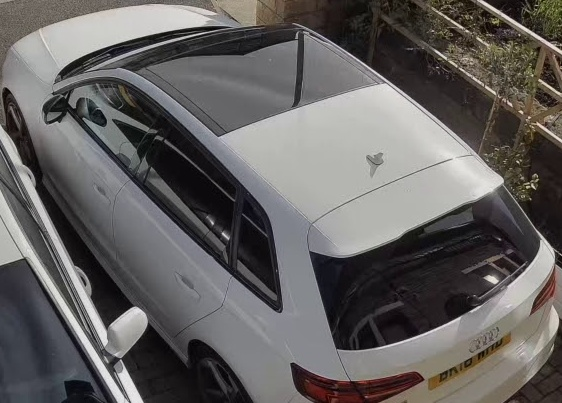


Object: car, Confidence: 0.92


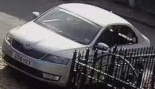


Object: car, Confidence: 0.91


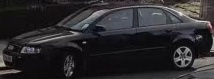


Object: car, Confidence: 0.91


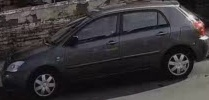


Object: car, Confidence: 0.91


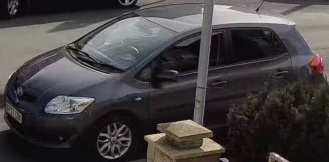


Object: car, Confidence: 0.89


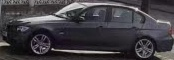


Object: car, Confidence: 0.88


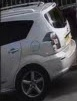


Object: car, Confidence: 0.88


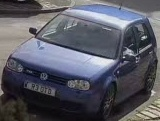


Object: car, Confidence: 0.84


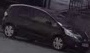


Object: car, Confidence: 0.84


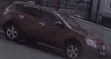


Object: car, Confidence: 0.62


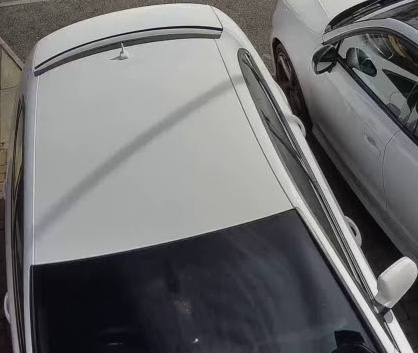


Object: car, Confidence: 0.48


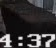

In [ ]:
display_cropped_images(updated_detections)

## Visualizing the Final Annotated Images

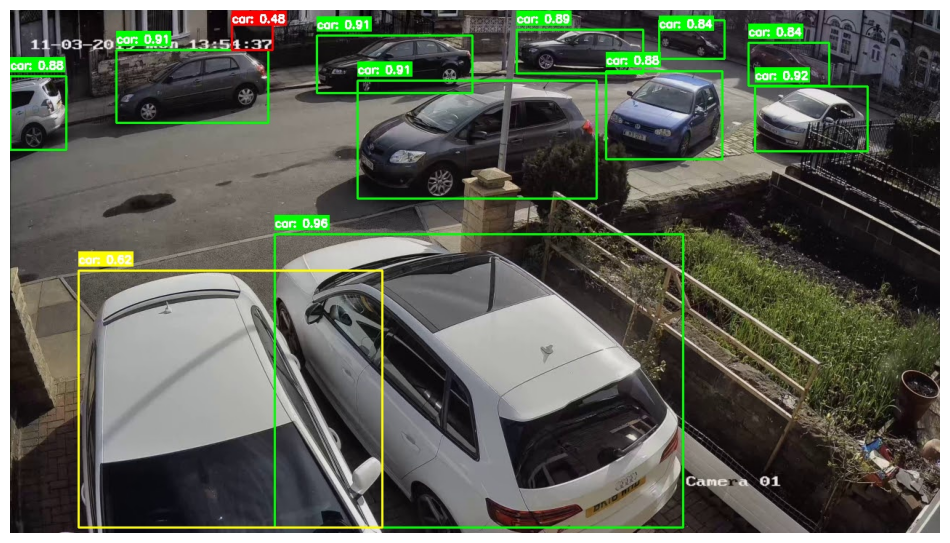

In [ ]:
import matplotlib.pyplot as plt
import cv2

def display_annotated_image():
    # Read the annotated image
    annotated_img = cv2.imread(output_path)

    # Convert BGR to RGB (OpenCV uses BGR by default)
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_img_rgb)
    plt.axis('off')
    plt.show()

# Display the image
display_annotated_image()

## Visualizing a single image that will be passsed to LLama Model as an Input


Object: car, Confidence: 0.96


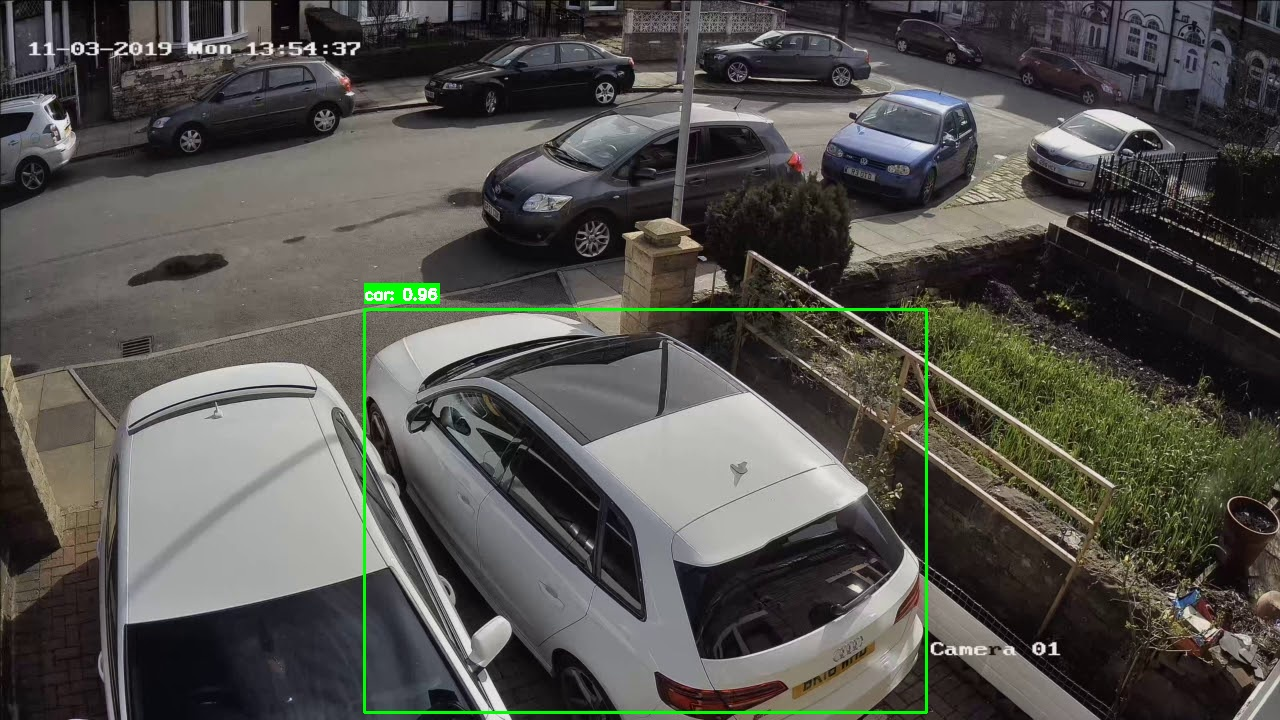

In [ ]:

from IPython.display import display
from PIL import Image

for detection in updated_detections:
    image = Image.open(detection['llama_input_path'])
    print(f"Object: {detection['object']}, Confidence: {detection['confidence']:.2f}")
    display(image)
    break

## Integrrating LLama 3.2 11 B Vision Model for generateing attributes and description

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments, GenerationConfig

We are using bits and bytes configuration to quantize the model to load it into the current GPU to process the images

In [ ]:
import torch

def create_bnb_config():
    bnb_4bit_compute_dtype = "float16"
    compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )
    return bnb_config

In [ ]:
quant_config = create_bnb_config()

## Loading the model and passing the quanitzation config

In [ ]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto",
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

## Preparing prompt for generating image outputs

In [ ]:
def create_prompt(detection):
    """Create analysis prompt for the detected object"""

    context = f"""You are a computer vision analysis system. Your ONLY role is to output valid JSON.

    INPUT:
    - Object: {detection['object']}
    - Confidence: {detection['confidence']:.2f}
    - Location: {detection['bounding_box']}

    STRICT REQUIREMENTS:
    1. Output MUST be valid parseable JSON
    2. Do NOT include ANY explanatory text, markdown, or other content
    3. Follow EXACTLY this schema:
    {{
        "description": "string",
        "attributes": {{
            "brand": "string",
            "color": "string",
            "uniqueness": "string"
        }}
    }}

    RULES:
    - description: Concise but detailed description of the {detection['object']} and context
    - brand: Use "N/A" if not visible
    - color: List main colors observed
    - uniqueness: Notable features or "N/A"
    - All values must be strings
    - No null values allowed, use "N/A" instead

    EXAMPLES:

    FOR A CHAIR:
    {{
        "description": "Modern ergonomic office chair positioned against white wall",
        "attributes": {{
            "brand": "Herman Miller",
            "color": "black mesh and silver aluminum",
            "uniqueness": "distinctive mesh back pattern with lumbar support"
        }}
    }}

    FOR A CAR:
    {{
        "description": "Luxury sedan parked in outdoor parking lot during daytime",
        "attributes": {{
            "brand": "Mercedes-Benz",
            "color": "metallic silver with black trim",
            "uniqueness": "distinctive panoramic sunroof and AMG wheels"
        }}
    }}

    OUTPUT MUST BE VALID JSON WITH NO ADDITIONAL TEXT."""


    return [
          {"role": "user", "content": [
              {"type": "image"},
              {"type": "text", "text": context}
          ]}
      ]

## Inference with LLama code

In [ ]:
def analyze_detection(processor, model, detection):
    """Analyze a single detection using the vision model"""
    try:
        # Load the image with bounding box from llama_input_path
        image = Image.open(detection['llama_input_path'])

        # Create messages with updated prompt
        messages = create_prompt(detection)

        # Process input
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        ).to(model.device)

        print(input_text)
        input_len = len(input_text) - 1

        print(input_len)

        # Generate response
        output = model.generate(**inputs, max_new_tokens=300)
        response = processor.decode(output[0])[input_len:].strip()
        response = response.split("<|eot_id|>")[0].strip()  # Apply strip again after splitting

        try:
            # Parse JSON response
            generated_content = json.loads(response)
            detection.update(generated_content)

        except json.JSONDecodeError:
            print(f"Failed to parse JSON for {detection['object']}")
            # Fallback if JSON parsing fails
            detection.update({
                "description": response.strip(),
                "attributes": {
                    "brand": "Unable to determine",
                    "color": "Unable to determine",
                    "uniqueness": "Unable to determine"
                }
            })

    except Exception as e:
        print(f"Error processing detection: {str(e)}")
        detection.update({
            "description": "Error processing image",
            "attributes": {
                "brand": "Error",
                "color": "Error",
                "uniqueness": "Error"
            }
        })

    return detection

In [ ]:
def process_detections(detections):
    """Process all detections"""
    # Setup model and processor

    # Process each detection
    enriched_detections = []
    for detection in detections:
        enriched_detection = analyze_detection(processor, model, detection)
        enriched_detections.append(enriched_detection)

    return enriched_detections

## Final Output and calling the llama function

In [ ]:
enriched_detections = process_detections(updated_detections)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>You are a computer vision analysis system. Your ONLY role is to output valid JSON.

    INPUT:
    - Object: car
    - Confidence: 0.96
    - Location: [364, 309, 926, 712]

    STRICT REQUIREMENTS:
    1. Output MUST be valid parseable JSON
    2. Do NOT include ANY explanatory text, markdown, or other content
    3. Follow EXACTLY this schema:
    {
        "description": "string",
        "attributes": {
            "brand": "string",
            "color": "string",
            "uniqueness": "string"
        }
    }

    RULES:
    - description: Concise but detailed description of the car and context
    - brand: Use "N/A" if not visible
    - color: List main colors observed
    - uniqueness: Notable features or "N/A"
    - All values must be strings
    - No null values allowed, use "N/A" instead

    EXAMPLES:

    FOR A CHAIR:
    {
        "description": "Modern ergonomic office chair positioned against white w

In [ ]:
print(enriched_detections[1]['description'])

Luxury sedan parked on street in residential area during daytime


In [ ]:
enriched_detections

[{'filename': 'test_parked_cars.jpg',
  'object': 'car',
  'confidence': 0.9561308026313782,
  'bounding_box': [364, 309, 926, 712],
  'cropped_filename': 'car_0.96_test_parked_cars_0.jpg',
  'description': 'Luxury sedan parked in outdoor parking lot during daytime',
  'attributes': {'brand': 'N/A', 'color': 'white', 'uniqueness': 'N/A'},
  'llama_input_path': 'llama_input/test_parked_cars/car_1_0.96.jpg'},
 {'filename': 'test_parked_cars.jpg',
  'object': 'car',
  'confidence': 0.9176064133644104,
  'bounding_box': [1025, 106, 1180, 195],
  'cropped_filename': 'car_0.92_test_parked_cars_1.jpg',
  'description': 'Luxury sedan parked on street in residential area during daytime',
  'attributes': {'brand': 'N/A', 'color': 'white', 'uniqueness': 'N/A'},
  'llama_input_path': 'llama_input/test_parked_cars/car_2_0.92.jpg'},
 {'filename': 'test_parked_cars.jpg',
  'object': 'car',
  'confidence': 0.9115621447563171,
  'bounding_box': [422, 36, 636, 115],
  'cropped_filename': 'car_0.91_test_

## Final Output Being Saved to Metadata.json

In [ ]:
with open("meta_data.json", 'w') as f:
        json.dump(enriched_detections, f, indent=4)